## Data Importing and Pre-processing

In [86]:
# import libraries needed
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.*")
%matplotlib inline

In [87]:
# read file and see number of rows and cols
nba_df = pd.read_csv("full_nba_salaries.csv")
nba_df.shape

(20883, 36)

In [88]:
nba_df.head()

,Unnamed: 0,Season,Age,Tm,Lg_x,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Name,Team,Lg_y,Salary
0,13831,1979-80,20,LAL,NBA,SG,77,NaN,36.3,6.5,12.3,.530,0.1,0.4,.226,6.4,11.9,.540,.534,4.9,6.0,.810,2.2,5.6,7.7,7.3,2.4,0.5,4.0,2.8,18.0,"AS,ROY-2",Magic Johnson,Los Angeles Lakers,NBA,"$460,000"
1,17822,1979-80,23,BOS,NBA,PF,82,82,36.0,8.5,17.8,0.474,0.7,1.7,0.406,7.7,16.1,0.481,0.494,3.7,4.4,0.836,2.6,7.8,10.4,4.5,1.7,0.6,3.2,3.4,21.3,"MVP-4,NBA1,AS,ROY-1",Larry Bird,Boston Celtics,NBA,"$650,000"
2,17823,1980-81,24,BOS,NBA,PF,82,82,39.5,8.8,18.3,0.478,0.2,0.9,0.27,8.5,17.4,0.489,0.485,3.5,4.0,0.863,2.3,8.6,10.9,5.5,2.0,0.8,3.5,2.9,21.2,"MVP-2,NBA1,AS",Larry Bird,Boston Celtics,NBA,"$650,000"
3,13832,1980-81,21,LAL,NBA,SG,37,NaN,37.1,8.4,15.9,.532,0.1,0.5,.176,8.4,15.4,.542,.534,4.6,6.1,.760,2.7,5.9,8.6,8.6,3.4,0.7,3.9,2.7,21.6,MVP-11,Magic Johnson,Los Angeles Lakers,NBA,"$460,000"
4,17824,1981-82,25,BOS,NBA,PF,77,58,38.0,9.2,18.4,0.503,0.1,0.7,0.212,9.1,17.7,0.514,0.507,4.3,4.9,0.863,2.6,8.3,10.9,5.8,1.9,0.9,3.3,3.2,22.9,"MVP-2,NBA1,DEF2,AS",Larry Bird,Boston Celtics,NBA,"$650,000"


In [89]:
# remove 'Lg_x' and 'Lg_y' columns
# we understand that all of these players are in the NBA so having a column that all says they are in the nba, twice, is unnecessary 
nba_df = nba_df.drop(['Lg_x', 'Lg_y'], axis=1)

# remove the 'Team' column because we already have 'Tm' 
nba_df = nba_df.drop(columns=['Team'])

# reanme 'Unnamed: 0' column to 'ID'
nba_df = nba_df.rename(columns={"Unnamed: 0": "Id"})

In [90]:
print(nba_df.dtypes)

# we see that there are categorical variables that should be labeled as numeric

Id         int64
Season    object
Age        int64
Tm        object
Pos       object
G         object
GS        object
MP        object
FG        object
FGA       object
FG%       object
3P        object
3PA       object
3P%       object
2P        object
2PA       object
2P%       object
eFG%      object
FT        object
FTA       object
FT%       object
ORB       object
DRB       object
TRB       object
AST       object
STL       object
BLK       object
TOV       object
PF        object
PTS       object
Awards    object
Name      object
Salary    object
dtype: object


In [91]:
# list all columns from 'MP' to 'AST' that need to be converted to float
col_to_be_floats = nba_df.loc[:, 'MP':'PTS'].columns.tolist()

# add additional columns 'G', 'GS', to the list
col_to_be_floats.extend(['G', 'GS'])

# convert each column to float, handling non-numeric entries
for column in col_to_be_floats:
    # convert non-convertible strings to NaN
    nba_df[column] = pd.to_numeric(nba_df[column], errors='coerce')

In [92]:
# remove the dollar sign and comma from the 'Salary' column
nba_df['Salary'] = nba_df['Salary'].str.replace('$', '', regex=False)
nba_df['Salary'] = nba_df['Salary'].str.replace(',', '', regex=False)

# remove the '(TW)' which stands for a two-way contract
nba_df['Salary'] = nba_df['Salary'].str.replace('(TW)', '', regex=False)

# convert to int
nba_df['Salary'] = nba_df['Salary'].astype(int)

In [93]:
# count number of categorical variables
category_count = 0

for cat in nba_df.dtypes:
    if cat == "object":
        category_count += 1

print("Number of categorical variables:", category_count)

# column 1 is the ID column so we subract 1
numeric_count = nba_df.shape[1] - category_count - 1

print("Number of contineous variables:", numeric_count)

Number of categorical variables: 5
Number of contineous variables: 27


In [94]:
nba_df.head()

,Id,Season,Age,Tm,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Name,Salary
0,13831,1979-80,20,LAL,SG,77.0,NaN,36.3,6.5,12.3,0.530,0.1,0.4,0.226,6.4,11.9,0.540,0.534,4.9,6.0,0.810,2.2,5.6,7.7,7.3,2.4,0.5,4.0,2.8,18.0,"AS,ROY-2",Magic Johnson,460000
1,17822,1979-80,23,BOS,PF,82.0,82.0,36.0,8.5,17.8,0.474,0.7,1.7,0.406,7.7,16.1,0.481,0.494,3.7,4.4,0.836,2.6,7.8,10.4,4.5,1.7,0.6,3.2,3.4,21.3,"MVP-4,NBA1,AS,ROY-1",Larry Bird,650000
2,17823,1980-81,24,BOS,PF,82.0,82.0,39.5,8.8,18.3,0.478,0.2,0.9,0.270,8.5,17.4,0.489,0.485,3.5,4.0,0.863,2.3,8.6,10.9,5.5,2.0,0.8,3.5,2.9,21.2,"MVP-2,NBA1,AS",Larry Bird,650000
3,13832,1980-81,21,LAL,SG,37.0,NaN,37.1,8.4,15.9,0.532,0.1,0.5,0.176,8.4,15.4,0.542,0.534,4.6,6.1,0.760,2.7,5.9,8.6,8.6,3.4,0.7,3.9,2.7,21.6,MVP-11,Magic Johnson,460000
4,17824,1981-82,25,BOS,PF,77.0,58.0,38.0,9.2,18.4,0.503,0.1,0.7,0.212,9.1,17.7,0.514,0.507,4.3,4.9,0.863,2.6,8.3,10.9,5.8,1.9,0.9,3.3,3.2,22.9,"MVP-2,NBA1,DEF2,AS",Larry Bird,650000


### Handling missing data

In [95]:
#Some rows are all labled "Did not play (injury/illness)". We can remove these rows as there is no valuable data
dnp_mask = nba_df['Pos'].str.startswith("Did ")
nba_df = nba_df[~dnp_mask]

In [96]:
# Some of the Awards data are null when they should just be marked as 'None'
nba_df['Awards'].fillna('None', inplace=True)

In [97]:
# display the missing data and its percent of the column
total_missing = nba_df.isnull().sum().sort_values(ascending=False)
percent_missing = (nba_df.isnull().sum() / nba_df.isnull().count()).sort_values(ascending=False)

missing_data_df = pd.concat([total_missing, percent_missing], axis=1, keys=["Total Missing", "Percent Missing"])
missing_data_df

,Total Missing,Percent Missing
3P%,3290,0.157544
FT%,1233,0.059043
2P%,502,0.024039
FG%,419,0.020064
eFG%,419,0.020064
GS,315,0.015084
PF,0,0.000000
TOV,0,0.000000
BLK,0,0.000000
PF,313,0.014988


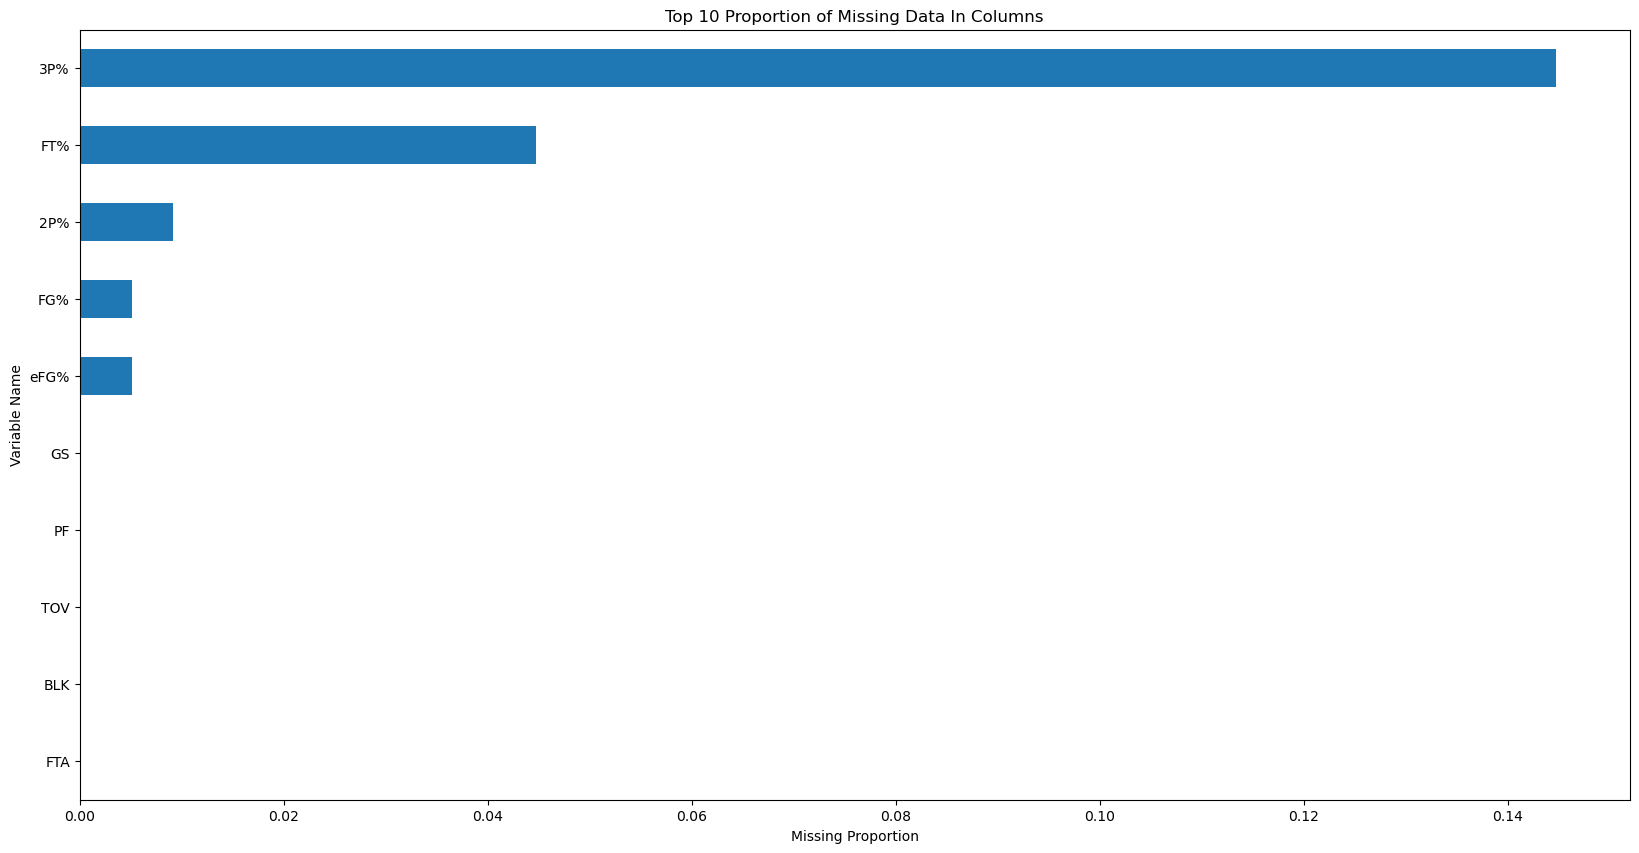

In [98]:
# visualize this in a bar graph
missing_data_df["Percent Missing"].head(10).plot(
    kind="barh", figsize=(20, 10)
).invert_yaxis()  # top 10 missing columns
plt.xlabel("Missing Proportion")
plt.ylabel("Variable Name")
plt.title("Top 10 Proportion of Missing Data In Columns")
plt.show()

In [49]:
# see what the null values are for 'GS'
null_gs = nba_df[nba_df['GS'].isnull()]
null_gs.head()

,Id,Season,Age,Tm,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Name,Salary
0,13831,1979-80,20,LAL,SG,77.0,NaN,36.3,6.5,12.3,0.530,0.1,0.4,0.226,6.4,11.9,0.540,0.534,4.9,6.0,0.81,2.2,5.6,7.7,7.3,2.4,0.5,4.0,2.8,18.0,"AS,ROY-2",Magic Johnson,460000
3,13832,1980-81,21,LAL,SG,37.0,NaN,37.1,8.4,15.9,0.532,0.1,0.5,0.176,8.4,15.4,0.542,0.534,4.6,6.1,0.76,2.7,5.9,8.6,8.6,3.4,0.7,3.9,2.7,21.6,MVP-11,Magic Johnson,460000


In [53]:
# impute Magic Johnson's null values of games started to be equal to his games, since stat was never recorded
nba_df['GS'] = nba_df['GS'].fillna(nba_df['G'])